In [13]:
!pip uninstall -y protobuf -q
!pip install -q "protobuf==4.25.3"


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import google.protobuf
print("protobuf:", google.protobuf.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


2025-12-14 21:16:12.523350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765746972.544444    1162 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765746972.550725    1162 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


protobuf: 4.25.3
Device: cuda


In [2]:
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"


In [3]:
base_ds = datasets.ImageFolder(DATA_DIR)  # no transform yet
y_all = np.array(base_ds.targets)
n = len(base_ds)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(np.zeros(n), y_all))

train_idx = np.array(train_idx)
test_idx  = np.array(test_idx)

print("Total:", n, "Train:", len(train_idx), "Test:", len(test_idx))
print("Num classes:", len(base_ds.classes))


Total: 1016 Train: 812 Test: 204
Num classes: 11


In [4]:
# SimCLR Augmentation Recipe (documented):
# 1) RandomResizedCrop(224)
# 2) RandomHorizontalFlip
# 3) RandomRotation(20)               (microscopy-friendly)
# 4) ColorJitter (mild)
# 5) RandomGrayscale(p=0.2)
# 6) GaussianBlur(kernel_size=9)
# 7) Normalize with ImageNet stats

class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)

simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [5]:
ssl_ds = datasets.ImageFolder(DATA_DIR, transform=TwoCropsTransform(simclr_transform))
train_ssl = Subset(ssl_ds, train_idx)

train_ssl_loader = DataLoader(train_ssl, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
print("SSL train batches:", len(train_ssl_loader))


SSL train batches: 12


In [6]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, out_dim=128):
        super().__init__()
        self.encoder = base_encoder
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.proj = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_dim)
        )
    def forward(self, x):
        h = self.encoder(x)
        z = self.proj(h)
        return F.normalize(z, dim=1)

def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)             # (2N,D)
    sim = torch.mm(z, z.t()) / temperature       # (2N,2N)
    mask = torch.eye(2*N, device=z.device, dtype=torch.bool)
    sim = sim.masked_fill(mask, -1e9)
    targets = torch.arange(2*N, device=z.device)
    targets = (targets + N) % (2*N)
    return F.cross_entropy(sim, targets)

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
ssl_model = SimCLR(resnet50).to(device)


In [7]:
optimizer = optim.Adam(ssl_model.parameters(), lr=3e-4, weight_decay=1e-4)
epochs_ssl = 50
ssl_loss_hist = []

for epoch in range(epochs_ssl):
    ssl_model.train()
    total = 0.0
    for (xi, xj), _ in train_ssl_loader:
        xi, xj = xi.to(device), xj.to(device)
        zi = ssl_model(xi)
        zj = ssl_model(xj)
        loss = nt_xent_loss(zi, zj, temperature=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()

    avg_loss = total / len(train_ssl_loader)
    ssl_loss_hist.append(avg_loss)
    print(f"[SSL] Epoch {epoch+1}/{epochs_ssl} loss={avg_loss:.4f}")

# Save frozen encoder (requirement 5.1)
torch.save(ssl_model.encoder.state_dict(), "simclr_frozen_encoder.pt")
print("Saved: simclr_frozen_encoder.pt")


[SSL] Epoch 1/50 loss=4.0815
[SSL] Epoch 2/50 loss=3.7729
[SSL] Epoch 3/50 loss=3.6466
[SSL] Epoch 4/50 loss=3.5738
[SSL] Epoch 5/50 loss=3.5626
[SSL] Epoch 6/50 loss=3.6107
[SSL] Epoch 7/50 loss=3.5334
[SSL] Epoch 8/50 loss=3.5376
[SSL] Epoch 9/50 loss=3.5332
[SSL] Epoch 10/50 loss=3.4936
[SSL] Epoch 11/50 loss=3.4674
[SSL] Epoch 12/50 loss=3.4607
[SSL] Epoch 13/50 loss=3.4489
[SSL] Epoch 14/50 loss=3.4265
[SSL] Epoch 15/50 loss=3.4348
[SSL] Epoch 16/50 loss=3.4112
[SSL] Epoch 17/50 loss=3.4174
[SSL] Epoch 18/50 loss=3.3769
[SSL] Epoch 19/50 loss=3.3900
[SSL] Epoch 20/50 loss=3.3630
[SSL] Epoch 21/50 loss=3.3467
[SSL] Epoch 22/50 loss=3.3682
[SSL] Epoch 23/50 loss=3.3652
[SSL] Epoch 24/50 loss=3.3374
[SSL] Epoch 25/50 loss=3.3471
[SSL] Epoch 26/50 loss=3.3606
[SSL] Epoch 27/50 loss=3.3297
[SSL] Epoch 28/50 loss=3.3551
[SSL] Epoch 29/50 loss=3.3346
[SSL] Epoch 30/50 loss=3.3048
[SSL] Epoch 31/50 loss=3.2963
[SSL] Epoch 32/50 loss=3.3320
[SSL] Epoch 33/50 loss=3.3022
[SSL] Epoch 34/50 l

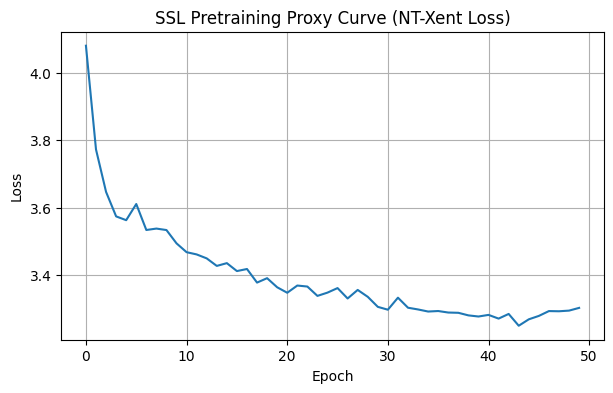

In [8]:
plt.figure(figsize=(7,4))
plt.plot(ssl_loss_hist)
plt.title("SSL Pretraining Proxy Curve (NT-Xent Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [9]:
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

probe_ds = datasets.ImageFolder(DATA_DIR, transform=eval_tf)
train_probe = Subset(probe_ds, train_idx)
test_probe  = Subset(probe_ds, test_idx)

train_probe_loader = DataLoader(train_probe, batch_size=64, shuffle=False, num_workers=2)
test_probe_loader  = DataLoader(test_probe, batch_size=64, shuffle=False, num_workers=2)

# Freeze encoder
for p in ssl_model.encoder.parameters():
    p.requires_grad = False
ssl_model.encoder.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
def extract_features(encoder, loader):
    encoder.eval()
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            f = encoder(x).cpu()
            feats.append(f)
            labels.append(y)
    return torch.cat(feats).numpy(), torch.cat(labels).numpy()

X_train, y_train = extract_features(ssl_model.encoder, train_probe_loader)
X_test,  y_test  = extract_features(ssl_model.encoder, test_probe_loader)

print("Frozen feature shape:", X_train.shape)
num_classes = len(probe_ds.classes)


Frozen feature shape: (812, 2048)


In [11]:
def per_class_accuracy(cm):
    # diag / row sum
    row_sum = cm.sum(axis=1).clip(min=1)
    return np.diag(cm) / row_sum

def eval_classifier(name, clf, Xtr, ytr, Xte, yte, plot_roc=True):
    # Train time
    t0 = time.time()
    clf.fit(Xtr, ytr)
    train_time = time.time() - t0

    # Test time
    t0 = time.time()
    ypred = clf.predict(Xte)
    test_time = time.time() - t0

    acc = accuracy_score(yte, ypred)
    cm = confusion_matrix(yte, ypred)
    pca = per_class_accuracy(cm)

    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(yte, ypred, average="weighted", zero_division=0)

    print("\n==============================")
    print(f"{name}")
    print("==============================")
    print("Accuracy:", acc)
    print("Weighted Precision:", prec_w)
    print("Weighted Recall:", rec_w)
    print("Weighted F1:", f1_w)
    print("Per-class Accuracy:", np.round(pca, 3))
    print("Train time (s):", round(train_time, 4), "Test time (s):", round(test_time, 4))
    print("Confusion Matrix:\n", cm)
    print(classification_report(yte, ypred, zero_division=0))

    # ROC-AUC (One-vs-Rest) if predict_proba exists
    if plot_roc and hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(Xte)
        y_bin = label_binarize(yte, classes=list(range(num_classes)))

        # Handle missing classes (rare but possible)
        present = y_bin.sum(axis=0) > 0
        aucs = []
        plt.figure(figsize=(7,5))
        for i in range(num_classes):
            if not present[i]:
                continue
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            auc_val = auc(fpr, tpr)
            aucs.append(auc_val)
            plt.plot(fpr, tpr, label=f"Class {i} AUC={auc_val:.3f}")

        plt.plot([0,1],[0,1],'--')
        plt.title(f"ROC Curves (OvR) — {name}")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(fontsize=8)
        plt.grid(True)
        plt.show()

        # Macro ROC-AUC (only present classes)
        macro_auc = np.mean(aucs) if len(aucs) else float("nan")
        print("Macro ROC-AUC (present classes):", macro_auc)

    return {
        "name": name,
        "acc": acc,
        "prec_w": prec_w,
        "rec_w": rec_w,
        "f1_w": f1_w,
        "train_time": train_time,
        "test_time": test_time
    }



Linear Probe (LogReg)
Accuracy: 0.7843137254901961
Weighted Precision: 0.7947890644239987
Weighted Recall: 0.7843137254901961
Weighted F1: 0.7857671819687723
Per-class Accuracy: [0.    0.857 0.889 1.    0.654 0.933 0.744 0.696 0.667 0.778 0.765]
Train time (s): 277.0353 Test time (s): 0.0037
Confusion Matrix:
 [[ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  2  1  0  0  0  0]
 [ 0  0 24  0  0  0  0  3  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  3  3  0  1  2]
 [ 0  0  0  0  0 28  1  1  0  0  0]
 [ 0  1  0  0  2  3 32  5  0  0  0]
 [ 0  0  0  0  2  0  4 16  0  1  0]
 [ 0  0  0  0  0  0  0  1  4  0  1]
 [ 0  0  0  0  0  0  0  1  1  7  0]
 [ 0  0  0  0  0  1  2  1  0  0 13]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.90      0.86      0.88        21
           2       1.00      0.89      0.94        27
           3       1.00      1.00      1.00         1
           4       

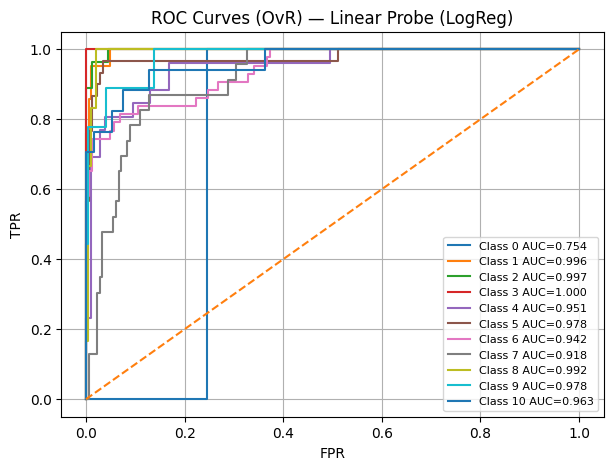

Macro ROC-AUC (present classes): 0.9517432943635604


In [12]:
linear_probe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, solver="saga")  # sklearn>=1.4: no multi_class arg
)

res_linear = eval_classifier("Linear Probe (LogReg)", linear_probe, X_train, y_train, X_test, y_test, plot_roc=True)



Shallow Head: MLP
Accuracy: 0.7058823529411765
Weighted Precision: 0.7595438439315214
Weighted Recall: 0.7058823529411765
Weighted F1: 0.7091597743351065
Per-class Accuracy: [0.    0.905 0.852 1.    0.385 0.867 0.581 0.826 0.667 0.778 0.588]
Train time (s): 1.7251 Test time (s): 0.0048
Confusion Matrix:
 [[ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  2  0  0  0  0]
 [ 0  0 23  0  0  0  0  4  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0 10  0  5  5  0  1  4]
 [ 0  0  0  0  0 26  2  1  0  0  1]
 [ 0  2  0  0  0  1 25 13  0  0  2]
 [ 0  0  0  0  0  1  3 19  0  0  0]
 [ 0  0  0  0  0  0  0  1  4  0  1]
 [ 0  0  0  0  0  0  0  1  1  7  0]
 [ 0  0  0  0  1  1  0  4  0  1 10]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.90      0.88        21
           2       0.96      0.85      0.90        27
           3       1.00      1.00      1.00         1
           4       0.91  

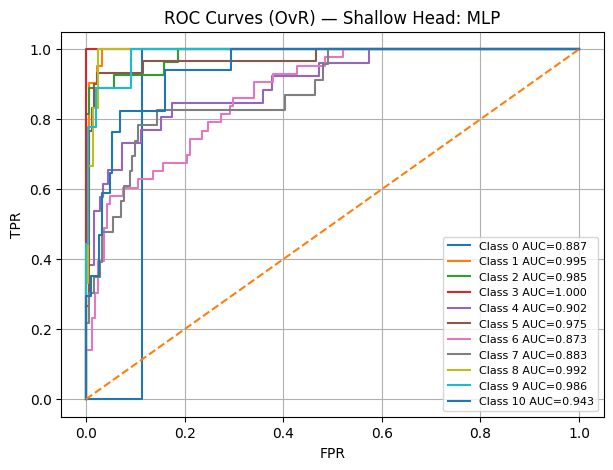

Macro ROC-AUC (present classes): 0.9472442236290516

Shallow Head: SVM (RBF)
Accuracy: 0.7107843137254902
Weighted Precision: 0.7242489444458136
Weighted Recall: 0.7107843137254902
Weighted F1: 0.7136776889446323
Per-class Accuracy: [0.    0.952 0.778 1.    0.577 0.833 0.698 0.565 0.5   0.778 0.588]
Train time (s): 2.2033 Test time (s): 0.1674
Confusion Matrix:
 [[ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  1  0  0  0  0]
 [ 0  0 21  0  0  0  4  2  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0 15  0  2  5  0  1  2]
 [ 0  0  0  0  1 25  1  0  1  0  2]
 [ 0  1  2  0  2  1 30  6  0  0  1]
 [ 0  0  0  0  2  0  8 13  0  0  0]
 [ 0  0  0  0  0  0  2  0  3  0  1]
 [ 0  0  0  0  0  0  0  1  1  7  0]
 [ 0  0  0  0  0  2  0  4  0  1 10]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.91      0.95      0.93        21
           2       0.88      0.78      0.82        27
           3       1.

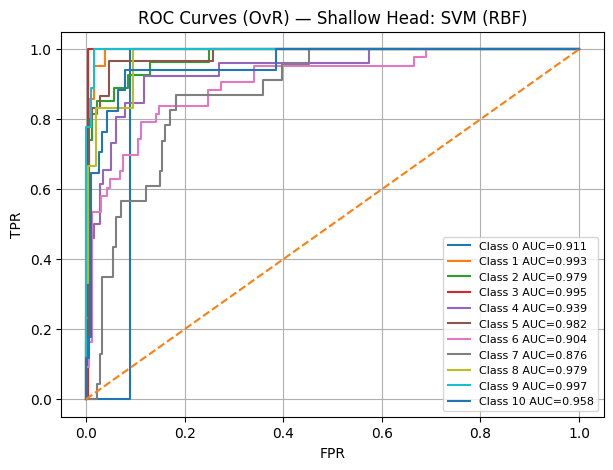

Macro ROC-AUC (present classes): 0.9557612977703218

Shallow Head: Decision Tree
Accuracy: 0.5392156862745098
Weighted Precision: 0.5454271182481369
Weighted Recall: 0.5392156862745098
Weighted F1: 0.5405648160589791
Per-class Accuracy: [0.    0.667 0.556 0.    0.5   0.633 0.465 0.391 0.5   0.778 0.588]
Train time (s): 1.7118 Test time (s): 0.0006
Confusion Matrix:
 [[ 0  0  0  0  0  1  0  0  0  0  0]
 [ 0 14  1  0  0  2  2  2  0  0  0]
 [ 0  2 15  1  2  1  3  3  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  1  0 13  1  5  3  0  1  2]
 [ 0  2  0  0  1 19  4  0  2  1  1]
 [ 0  3  3  1  4  6 20  4  0  0  2]
 [ 0  0  1  1  5  1  3  9  0  0  3]
 [ 0  0  0  0  1  0  1  1  3  0  0]
 [ 0  0  0  0  0  0  0  1  1  7  0]
 [ 0  1  0  0  0  2  2  1  0  1 10]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.64      0.67      0.65        21
           2       0.71      0.56      0.62        27
           3     

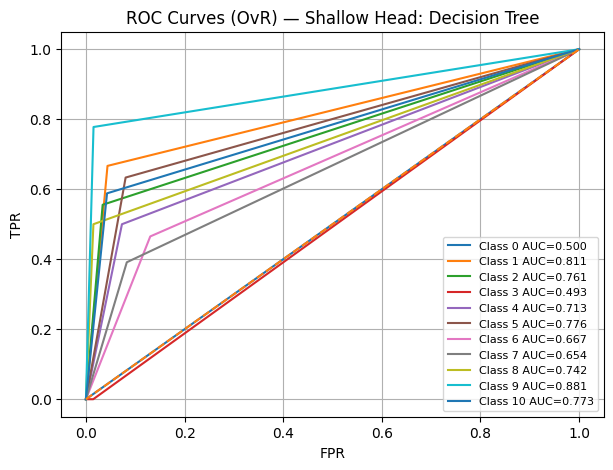

Macro ROC-AUC (present classes): 0.7066126685990711

Shallow Head: Random Forest
Accuracy: 0.6911764705882353
Weighted Precision: 0.7017227611121474
Weighted Recall: 0.6911764705882353
Weighted F1: 0.6903161947279594
Per-class Accuracy: [0.    0.667 0.815 0.    0.615 0.867 0.744 0.522 0.5   0.778 0.529]
Train time (s): 6.3189 Test time (s): 0.0352
Confusion Matrix:
 [[ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  2  5  0  0  0  0]
 [ 0  0 22  0  1  0  3  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 16  0  3  3  0  1  3]
 [ 0  0  0  0  1 26  2  0  0  1  0]
 [ 0  1  1  0  3  1 32  5  0  0  0]
 [ 0  0  0  0  3  1  7 12  0  0  0]
 [ 0  0  0  0  0  0  2  0  3  0  1]
 [ 0  0  0  0  0  0  0  1  1  7  0]
 [ 0  0  0  0  0  3  1  3  1  0  9]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.88      0.67      0.76        21
           2       0.96      0.81      0.88        27
           3     

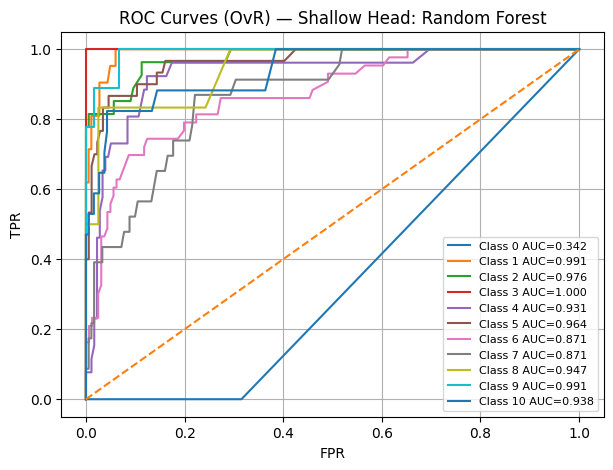

Macro ROC-AUC (present classes): 0.892901081974291


In [13]:
shallow_results = []

mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(512,), max_iter=200, random_state=42)
)
shallow_results.append(eval_classifier("Shallow Head: MLP", mlp, X_train, y_train, X_test, y_test, plot_roc=True))

svm = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf", C=10.0, gamma="scale", probability=True, random_state=42)
)
shallow_results.append(eval_classifier("Shallow Head: SVM (RBF)", svm, X_train, y_train, X_test, y_test, plot_roc=True))

dt = DecisionTreeClassifier(max_depth=None, random_state=42)
shallow_results.append(eval_classifier("Shallow Head: Decision Tree", dt, X_train, y_train, X_test, y_test, plot_roc=True))

rf = RandomForestClassifier(n_estimators=300, random_state=42)
shallow_results.append(eval_classifier("Shallow Head: Random Forest", rf, X_train, y_train, X_test, y_test, plot_roc=True))


In [14]:
for k in [1, 5, 20]:
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    print(f"kNN (k={k}) Accuracy:", accuracy_score(y_test, pred))


kNN (k=1) Accuracy: 0.5931372549019608
kNN (k=5) Accuracy: 0.5931372549019608
kNN (k=20) Accuracy: 0.6029411764705882


[FT] Epoch 1/20 loss=1.5593 train_acc=0.6293 test_acc=0.6275
[FT] Epoch 2/20 loss=1.0011 train_acc=0.6946 test_acc=0.5490
[FT] Epoch 3/20 loss=0.9214 train_acc=0.6047 test_acc=0.5588
[FT] Epoch 4/20 loss=0.7536 train_acc=0.7993 test_acc=0.7059
[FT] Epoch 5/20 loss=0.6556 train_acc=0.7672 test_acc=0.6716
[FT] Epoch 6/20 loss=0.6410 train_acc=0.8054 test_acc=0.6961
[FT] Epoch 7/20 loss=0.5855 train_acc=0.8214 test_acc=0.6618
[FT] Epoch 8/20 loss=0.5254 train_acc=0.8867 test_acc=0.7451
[FT] Epoch 9/20 loss=0.4225 train_acc=0.8658 test_acc=0.7598
[FT] Epoch 10/20 loss=0.3869 train_acc=0.9236 test_acc=0.7549
[FT] Epoch 11/20 loss=0.4011 train_acc=0.9249 test_acc=0.7892
[FT] Epoch 12/20 loss=0.3620 train_acc=0.9273 test_acc=0.7647
[FT] Epoch 13/20 loss=0.3779 train_acc=0.8830 test_acc=0.7451
[FT] Epoch 14/20 loss=0.3002 train_acc=0.9224 test_acc=0.7353
[FT] Epoch 15/20 loss=0.3280 train_acc=0.9027 test_acc=0.7402
[FT] Epoch 16/20 loss=0.3247 train_acc=0.9212 test_acc=0.8039
[FT] Epoch 17/20 

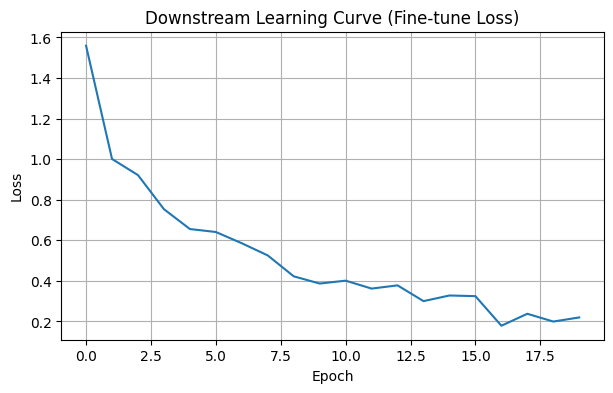

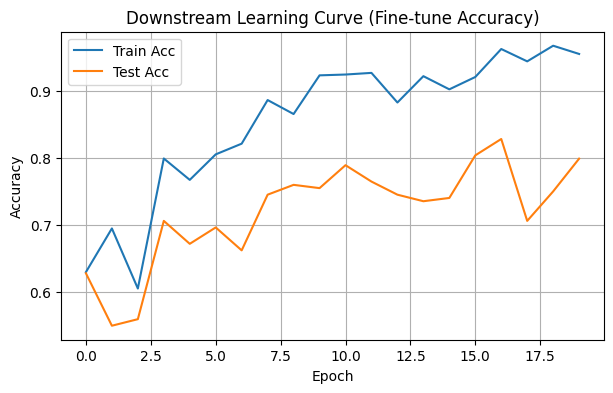

Fine-tune Accuracy: 0.7990196078431373
[[ 0  0  0  0  0  0  1  0  0  0  0]
 [ 0 20  0  0  1  0  0  0  0  0  0]
 [ 0  0 20  0  2  0  4  1  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  5  2  0  1  3]
 [ 0  0  0  0  0 28  1  0  0  0  1]
 [ 0  0  0  0  0  0 40  3  0  0  0]
 [ 0  1  0  0  0  0  5 16  0  0  1]
 [ 0  0  0  0  0  0  0  1  5  0  0]
 [ 0  0  0  0  0  0  1  1  0  7  0]
 [ 0  0  1  0  0  0  0  2  2  0 12]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.91      0.95      0.93        21
           2       0.95      0.74      0.83        27
           3       0.00      0.00      0.00         1
           4       0.83      0.58      0.68        26
           5       1.00      0.93      0.97        30
           6       0.70      0.93      0.80        43
           7       0.62      0.70      0.65        23
           8       0.71      0.83      0.77         6
           9       0.88

In [17]:
# Build finetune model: encoder + linear head
class FineTuneModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(2048, num_classes)
    def forward(self, x):
        f = self.encoder(x)
        return self.head(f)

# Create finetune datasets (supervised transform for training)
finetune_train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ft_ds = datasets.ImageFolder(DATA_DIR, transform=finetune_train_tf)
test_ft_ds  = datasets.ImageFolder(DATA_DIR, transform=eval_tf)

train_ft = Subset(train_ft_ds, train_idx)
test_ft  = Subset(test_ft_ds, test_idx)

train_ft_loader = DataLoader(train_ft, batch_size=32, shuffle=True, num_workers=2)
test_ft_loader  = DataLoader(test_ft, batch_size=32, shuffle=False, num_workers=2)

# Load frozen encoder weights (safety) and start finetuning from SSL encoder
encoder_ft = models.resnet50(weights=None)
encoder_ft.fc = nn.Identity()
encoder_ft.load_state_dict(torch.load("simclr_frozen_encoder.pt", map_location="cpu"))
encoder_ft = encoder_ft.to(device)

ft_model = FineTuneModel(encoder_ft, num_classes).to(device)

# Unfreeze strategy: fine-tune all (best accuracy), or only last block for cheaper training
for p in ft_model.encoder.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ft_model.parameters(), lr=3e-4, weight_decay=1e-4)

def torch_eval(model, loader):
    model.eval()
    correct, total = 0, 0
    ys, ps = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            ys.append(y.cpu().numpy())
            ps.append(pred.cpu().numpy())
    return correct/total, np.concatenate(ys), np.concatenate(ps)

epochs_ft = 20
train_acc_hist, test_acc_hist, train_loss_hist = [], [], []

t0_train = time.time()
for epoch in range(epochs_ft):
    ft_model.train()
    total_loss = 0.0

    for x, y in train_ft_loader:
        x, y = x.to(device), y.to(device)
        loss = criterion(ft_model(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Train acc proxy on a small pass (quick)
    tr_acc, _, _ = torch_eval(ft_model, train_ft_loader)
    te_acc, yt, yp = torch_eval(ft_model, test_ft_loader)

    train_loss_hist.append(total_loss / len(train_ft_loader))
    train_acc_hist.append(tr_acc)
    test_acc_hist.append(te_acc)

    print(f"[FT] Epoch {epoch+1}/{epochs_ft} loss={train_loss_hist[-1]:.4f} train_acc={tr_acc:.4f} test_acc={te_acc:.4f}")

ft_train_time = time.time() - t0_train

# inference time
t0 = time.time()
_ = torch_eval(ft_model, test_ft_loader)
ft_test_time = time.time() - t0

print("Fine-tune total train time (s):", round(ft_train_time, 2))
print("Fine-tune test eval time (s):", round(ft_test_time, 4))

# Downstream learning curves
plt.figure(figsize=(7,4))
plt.plot(train_loss_hist)
plt.title("Downstream Learning Curve (Fine-tune Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(test_acc_hist, label="Test Acc")
plt.title("Downstream Learning Curve (Fine-tune Accuracy)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Final fine-tune report
ft_acc, yt, yp = torch_eval(ft_model, test_ft_loader)
print("Fine-tune Accuracy:", ft_acc)
print(confusion_matrix(yt, yp))
print(classification_report(yt, yp, zero_division=0))


1% labels → Accuracy: 0.2010
5% labels → Accuracy: 0.3235
10% labels → Accuracy: 0.5049
25% labels → Accuracy: 0.5539
50% labels → Accuracy: 0.7010


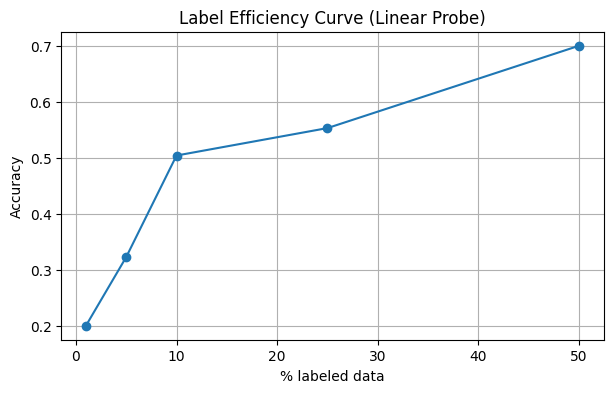

In [18]:
ratios = [0.01, 0.05, 0.10, 0.25, 0.50]
rng = np.random.default_rng(42)

eff_results = {}
classes = np.unique(y_train)

for r in ratios:
    X_small, y_small = [], []
    for c in classes:
        idx_c = np.where(y_train == c)[0]
        m = max(1, int(len(idx_c) * r))
        chosen = rng.choice(idx_c, m, replace=False)
        X_small.append(X_train[chosen])
        y_small.append(y_train[chosen])

    X_small = np.vstack(X_small)
    y_small = np.hstack(y_small)

    clf_eff = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, solver="saga"))
    clf_eff.fit(X_small, y_small)
    acc = clf_eff.score(X_test, y_test)
    eff_results[r] = acc
    print(f"{int(r*100)}% labels → Accuracy: {acc:.4f}")

plt.figure(figsize=(7,4))
plt.plot([r*100 for r in ratios], [eff_results[r] for r in ratios], marker="o")
plt.title("Label Efficiency Curve (Linear Probe)")
plt.xlabel("% labeled data")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


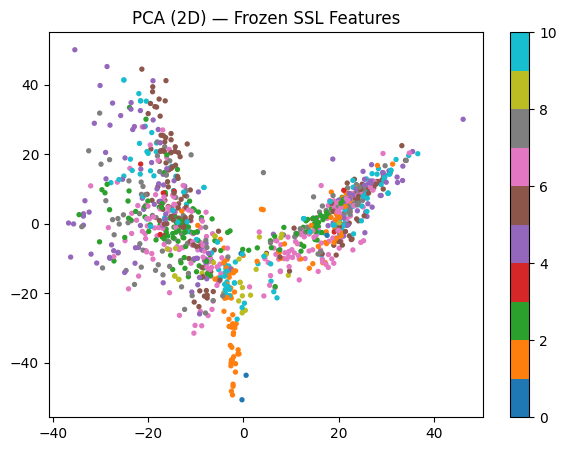

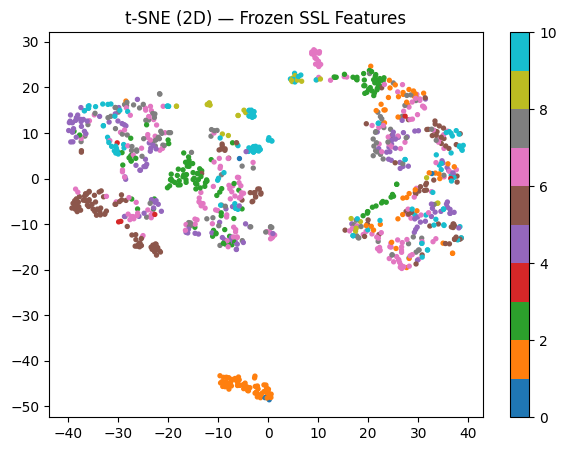

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


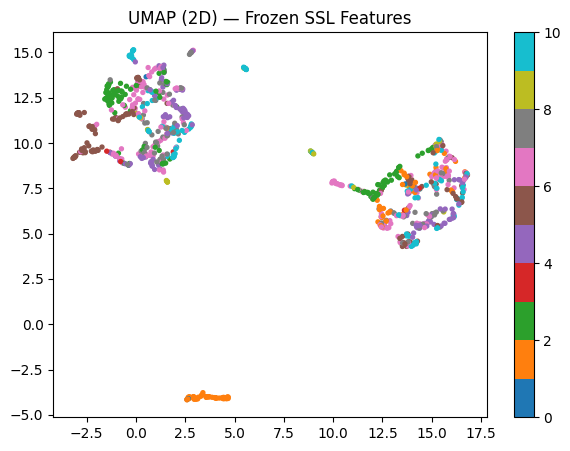

Silhouette Score: -0.033956170082092285


In [20]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import numpy as np

X_emb = np.concatenate([X_train, X_test], axis=0)
y_emb = np.concatenate([y_train, y_test], axis=0)

X_scaled = StandardScaler().fit_transform(X_emb)

# PCA
pca = PCA(n_components=2, random_state=42)
pca_res = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(pca_res[:,0], pca_res[:,1], c=y_emb, s=8, cmap="tab10")
plt.title("PCA (2D) — Frozen SSL Features")
plt.colorbar()
plt.show()

# t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
tsne_res = tsne.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y_emb, s=8, cmap="tab10")
plt.title("t-SNE (2D) — Frozen SSL Features")
plt.colorbar()
plt.show()

# UMAP
um = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)
um_res = um.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(um_res[:,0], um_res[:,1], c=y_emb, s=8, cmap="tab10")
plt.title("UMAP (2D) — Frozen SSL Features")
plt.colorbar()
plt.show()

# Silhouette score
sil = silhouette_score(X_scaled, y_emb, metric="euclidean")
print("Silhouette Score:", sil)


In [21]:
!pip install thop -q
from thop import profile

dummy = torch.randn(1,3,224,224).to(device)

# Frozen encoder GFLOPs
macs_enc, params_enc = profile(ssl_model.encoder, inputs=(dummy,), verbose=False)
print("Frozen Encoder GFLOPs:", macs_enc/1e9)
print("Frozen Encoder Params (M):", params_enc/1e6)

# Fine-tune model GFLOPs (encoder+head)
macs_ft, params_ft = profile(ft_model, inputs=(dummy,), verbose=False)
print("Fine-tune Model GFLOPs:", macs_ft/1e9)
print("Fine-tune Model Params (M):", params_ft/1e6)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.7 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [22]:
from pandas import DataFrame

# Fill these after running each SSL method notebook (SimCLR, BYOL, MoCo, etc.)
rows = [
    {
        "SSL Method": "SimCLR",
        "Linear Probe Acc": res_linear["acc"],
        "Fine-tune Acc": float(ft_acc),
        "kNN@5 Acc": float(make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)).fit(X_train, y_train).score(X_test, y_test)),
        "Silhouette": float(sil),
        "Encoder GFLOPs": float(macs_enc/1e9),
        "Encoder Params(M)": float(params_enc/1e6),
        "Linear Probe Train Time(s)": float(res_linear["train_time"]),
        "Linear Probe Test Time(s)": float(res_linear["test_time"]),
    },
    # Add rows here for other SSL methods after you run them in separate notebooks
]

df = DataFrame(rows)
df


,SSL Method,Linear Probe Acc,Fine-tune Acc,kNN@5 Acc,Silhouette,Encoder GFLOPs,Encoder Params(M),Linear Probe Train Time(s),Linear Probe Test Time(s)
0,SimCLR,0.784314,0.79902,0.593137,-0.033956,4.131695,23.508032,277.035295,0.003749
